# Image Super-Resolution via Iterative Refinement

#### With additional functions upon the original codes

*Code Writer: Chaeeun Ryu*

references: 
- https://nn.labml.ai/diffusion/ddpm/unet.html
- https://github.com/KiUngSong/Generative-Models/tree/main
- https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement/
- https://arxiv.org/abs/2102.09672
- https://arxiv.org/pdf/2104.14951.pdf

In [99]:
import torch, torchvision
from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from einops import rearrange, repeat
from tqdm.auto import tqdm
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math, os, copy

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Define U-net Architecture:

Approximate reverse diffusion process by using U-net<br>
U-net of SR3 : U-net backbone + Positional Encoding of time + Multihead Self-Attention

**Swish activation function**

In [198]:
class Swish(nn.Module):
    def forward(self,x):
        return x*torch.sigmoid(x)

In [199]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        # Input : tensor of value of coefficient alpha at specific step of diffusion process e.g. torch.Tensor([0.03])
        # Transform level of noise into representation of given desired dimension
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding

class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(nn.Linear(in_channels, out_channels*(1+self.use_affine_level)))

    def forward(self, x, noise_embed):
        noise = self.noise_func(noise_embed).view(x.shape[0], -1, 1, 1)
        if self.use_affine_level:
            gamma, beta = noise.chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + noise
        return x

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))

class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)

# Linear Multi-head Self-attention
class SelfAtt(nn.Module):
    def __init__(self, channel_dim, num_heads, norm_groups=32):
        super(SelfAtt,self).__init__()        
        self.groupnorm = nn.GroupNorm(norm_groups, channel_dim)
        self.num_heads = num_heads
        self.qkv = nn.Conv2d(channel_dim, channel_dim * 3, 1, bias=False)
        self.proj = nn.Conv2d(channel_dim, channel_dim, 1)

    def forward(self,x):
        b, c, h, w = x.size()
        x = self.groupnorm(x)
        qkv = rearrange(self.qkv(x), "b (qkv heads c) h w -> (qkv) b heads c (h w)", heads=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]

        keys = F.softmax(keys, dim=-1)
        att = torch.einsum('bhdn,bhen->bhde', keys, values)
        out = torch.einsum('bhde,bhdn->bhen', att, queries)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.num_heads, h=h, w=w)

        return self.proj(out)


class ResBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, 
                    num_heads=1, use_affine_level=False, norm_groups=32, att=True):
        super().__init__()
        self.noise_func = FeatureWiseAffine(noise_level_emb_dim, dim_out, use_affine_level)
        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        self.att = att
        self.attn = SelfAtt(dim_out, num_heads=num_heads, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        y = self.block1(x)
        y = self.noise_func(y, time_emb)
        y = self.block2(y)
        x = y + self.res_conv(x)
        if self.att:
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channel=6, out_channel=3, inner_channel=32, norm_groups=32,
        channel_mults=[1, 2, 4, 8, 8], res_blocks=3, dropout=0, img_size=128):
        super().__init__()

        noise_level_channel = inner_channel
        self.noise_level_mlp = nn.Sequential(
            PositionalEncoding(inner_channel),
            nn.Linear(inner_channel, inner_channel * 4),
            Swish(), 
            nn.Linear(inner_channel * 4, inner_channel)
        )

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = img_size

        # Downsampling stage of U-net
        downs = [nn.Conv2d(in_channel, inner_channel, kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResBlock(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, 
                    norm_groups=norm_groups, dropout=dropout))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResBlock(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, 
                            norm_groups=norm_groups, dropout=dropout),
            ResBlock(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, 
                        norm_groups=norm_groups, dropout=dropout, att=False)
        ])

        # Upsampling stage of U-net
        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResBlock(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, 
                    norm_groups=norm_groups, dropout=dropout))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, out_channel, groups=norm_groups)

    def forward(self, x, noise_level):
        # Embedding of time step with noise coefficient alpha
        t = self.noise_level_mlp(noise_level)
        
        feats = []
        for layer in self.downs:
            if isinstance(layer, ResBlock):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            x = layer(x, t)

        for layer in self.ups:
            if isinstance(layer, ResBlock):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)

register_buffer: 연산하는데 GPU를 사용하지만, backpropagation을 통해 update는 안 되는 값을 저장할 때 사용

# Diffusion Process Framework

#### TL;DR: Predict noise! 

**Contributions**
- Huber loss added as loss type
- lengthened linear schedule added for schedule types

<br><br><br>

##### Diffusion Computations

Computing $x_t$ directly in **forward process**, given $x_0$<br><br>
$$x_t = \sqrt{\bar{\alpha}_{t}}x_0 + \sqrt{1-\bar{\alpha}_{t} }\epsilon$$
$\alpha_t := 1-\beta_t$<br>
$\bar{\alpha}_t := \Pi^t_{s=0}\alpha_s$<br>
$q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)I)$<br>
$x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t-\sqrt{1-\bar{\alpha}_t}\epsilon)$
$=\frac{1}{\sqrt{\bar{\alpha}_t}}x_t - \sqrt{\frac{1}{\bar{\alpha}_t}-1}\epsilon$

<br><br>
Computing mean and variance of posteriors for **reverse process**

$$q(x_{t-1}|x_t,x_0) \sim \mathcal{N}(x_{t-1}; \tilde{\mu_t}(x_0,x_t),\tilde{\beta_t}(x_0,x_t)I)$$

$\tilde{\mu_t}(x_0,x_t) = \frac{\beta_t(\sqrt{\bar{\alpha}_{t-1}})}{1-\bar{\alpha}_t}x_0+\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\alpha_t}x_t$<br>
$\tilde{\beta_t}(x_0,x_t) = \beta_t(\frac{1-\bar{\alpha}_{t-1}}{1-\alpha_t})$

In [243]:
class Diffusion(nn.Module):
    def __init__(self, model, device, img_size, LR_size, channels = 3):
        super().__init__()
        self.channels = channels
        self.device = device
        self.model = model.to(self.device)
        self.img_size = img_size
        self.LR_size = LR_size
    
    def show_my_options(self):
        print("===Possible beta scheduling types===")
        print("1. cosine")
        print("2. lengthened_linear")
        print()
        print("===Possible loss types===")
        print("1. l1")
        print("2. l2")
        print("3. Huber Loss")
        print()
        
    #Set loss type
    def set_loss(self, type_):
        if type_ == 'l1':
            print(f"loss type: L1")
            self.loss_func = nn.L1Loss(reduction = 'sum')
        elif type_ == 'l2':
            print(f"loss type: L2")
            self.loss_func = nn.MSELoss(reduction='sum')
        else:
            print(f"loss type: Huber Loss")
            self.loss_func = nn.HuberLoss(reduction = 'sum')
            
    #Set scheduling for Beta as Cosine, and also modifications to Cosine
    def make_beta_schedule(self, schedule_type, n_timestep,linear_start,linear_end):
        if schedule_type == 'cosine':
            cosine_s = 8e-3
            timesteps = torch.arange(n_timestep+1,dtype = torch.float64)/n_timestep + cosine_s
            alphas = timesteps/(1+cosine_s)*math.pi/2
            alphas = alphas/alphas[0]
            betas = 1 - alphas[1:]/alphas[:-1]
            betas = betas.clamp(max = 0.999)
            return betas
        
        elif schedule_type == 'lengthened_linear':
            #original linear start: 0.0001
            #original linear end: 0.02
            linear_start = 0.00001
            linear_end = 0.005
            betas = np.linspace(linear_start, linear_end, n_timestep, dtype=np.float64)
            return betas
        else:
            print("schedule tpe not assigned properly!")
            return
    
    def set_new_noise_schedule(self, schedule_option):
        #schedule_opt = {'schedule':'cosine', 'n_timestep':2000, 'linear_start':None,'linear_end':None}
        to_torch = partial(torch.tensor, dtype=torch.float32, device=self.device)#지정된 type으로 torch tensor 만드는 함수
        betas = self.make_beta_schedule(
            schedule_type=schedule_opt['schedule'],
            n_timestep=schedule_opt['n_timestep'],
            linear_start=schedule_opt['linear_start'],
            linear_end=schedule_opt['linear_end'])
        betas = betas.detach().cpu().numpy() if isinstance(betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])#마지막 t번째 alpha 제외한 나머지끼리의 곱
        self.sqrt_alphas_cumprod_prev = np.sqrt(np.append(1., alphas_cumprod))
        
        self.num_timesteps = int(len(betas))
        
        # Coefficient for forward diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))#\bar{alpha_t}
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))#\bar{alpha_t-1}
        #forward process에서 x0을 예측할 때 x_t앞의 coefficient
        self.register_buffer('pred_coef_xt', to_torch(np.sqrt(1. / alphas_cumprod)))
        #forward process에서 x0을 예측할 때 noise앞의 (-1)*coefficient
        self.register_buffer('pred_coef_noise', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        ###Coefficient for reverse diffusion posterior q(x_{t-1} | x_t, x_0)
        #reverse process에서 posterior variance 구할 때 Beta_t의 coefficient (=variance)
        variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)#predicted variance for reverse process
        self.register_buffer('variance', to_torch(variance))
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(variance, 1e-20))))
        #reverse process에서 posterior mean 구할 때 x0앞 coefficient
        self.register_buffer('posterior_mean_coef_x0', to_torch(betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        #reverse process에서 posterior mean 구할 때 xt앞 coefficient
        self.register_buffer('posterior_mean_coef_xt', to_torch((1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))
        
    def predict_x0(self, x_t, t, noise):#x0을 위 공식대로 구함
        return self.pred_coef_xt[t]*x_t - self.pred_coef_noise[t]*noise
    
    def q_posterior(self,x_start,x_t,t):
        posterior_mu = self.posterior_mean_coef_x0[t]*x_start + self.posterior_mean_coef_xt[t]*x_t
        posterior_log_var = self.posterior_log_variance_clipped[t]
        return posterior_mu, posterior_log_var         
    
    #construct x0 and predict q's mean variance (=reverse process)
    def q_mean_variance(self, x, t, clip_denoised:bool, condition_x = None):
        batch_size = x.shape[0]
        noise_level = torch.FloatTensor([self.sqrt_alphas_cumprod_prev[t+1]]).repeat(batch_size,1).to(x.device)
        x_recon = self.predict_start(x,t,noise = self.model(torch.cat([condition_x,x],dim = 1),noise_level))#reconstruct x0
        
        if clip_denoised:
            x_recon.clamp_(-1.,1.)
        mean, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t = x, t=t)
        return mean, posterior_log_variance

    @torch.no_grad()
    def p_sample(self,x,t,clip_denoised = True, condition_x = None):
        mean, log_variance = self.q_mean_variance(x=x,t=t,clip_denoised=clip_denoised,condition_x=condition_x)
        noise = torch.rand_like(x) if t>0 else torch.zeros_like(x)
        return mean+noise*(0.5*log_variance).exp()
    
    @torch.no_grad()
    def super_resolution(self,x_in):
        img = torch.rand_like(x_in,device=x_in.device)
        for i in reversed(range(0,self.num_timesteps)):
            img = self.p_sample(img,i,condition_x=x_in)
        return img
    
    def p_losses(self,x_in):
        x_start = x_in
        #lr_imgs: made low resolution images
        lr_imgs = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(x_in))
        b,c,h,w = x_start.shape
        t = np.random.randint(1,self.num_timesteps+1)
        sqrt_alpha = torch.FloatTensor(np.random.uniform(self.sqrt_alphas_cumprod_prev[t-1], self.sqrt_alphas_cumprod_prev[t],size = b)).to(x_start.device)
        sqrt_alpha = sqrt_alpha.view(-1,1,1,1)
        noise = torch.rand_like(x_start).to(x_start.device)
        #perturbed image
        x_noisy = sqrt_alpha*x_start+(1-sqrt_alpha**2).sqrt()*noise
        pred_noise = self.model(torch.cat([lr_imgs,x_noisy],dim = 1),noise_level=sqrt_alpha)
        return self.loss_func(noise,pred_noise)
    
    def forward(self,x,*args,**kwargs):
        return self.p_losses(x,*args,**kwargs)

# Image Super-Resolution via Iterative Refinement(SR3)

In [244]:
global args_dict
args_dict = dict()
args_dict['load_path'] = None
args_dict['load'] = False
args_dict['in_channel'] = 6
args_dict['out_channel'] = 3
args_dict['inner_channel'] = 32
args_dict['norm_groups'] = 8
args_dict['channel_mults'] = (1, 2, 4, 8, 8)
args_dict['res_blocks'] = 3
args_dict['dropout'] = 0
args_dict['lr'] = 1e-5
args_dict['distributed'] = False

In [257]:
import copy
class SR3:
    def __init__(self, args_dict,schedule_opt):
        self.dataloader = args_dict['dataloader']
        self.testloader = args_dict['testloader']
        self.device = args_dict['device']
        self.save_path = args_dict['save_path']
        self.img_size = args_dict['img_size']
        self.LR_size = args_dict['LR_size']
        
        '''
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=32,
        channel_mults=(1, 2, 4, 8, 8),
        attn_res=(8),
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=128
    ):
    '''
        model = UNet(in_channel=args_dict['in_channel'], out_channel=args_dict['out_channel'], inner_channel=args_dict['inner_channel'], norm_groups=args_dict['norm_groups'], channel_mults=args_dict['channel_mults'], res_blocks=args_dict['res_blocks'], dropout=args_dict['dropout'], img_size = args_dict['img_size'])
        self.sr3 = Diffusion(model, self.device, self.img_size, self.LR_size, args_dict['out_channel'])
        
        #Apply weight initialization & set loss & set noise schedule
        self.sr3.apply(self.weights_init_orthogonal)
        self.sr3.set_loss(args_dict['loss_type'])
        self.sr3.set_new_noise_schedule(schedule_opt)
        
        self.optimizer = torch.optim.Adam(self.sr3.parameters(), lr = args_dict['lr'])
    
    def n_params(self):
        params = sum(p.numel() for p in self.sr3.parameters())
        print(f"Number of model parameters : {params}")
        return
    
    def show_my_options(self):
        self.sr3.show_my_options()
        return
    
    def weights_init_orthogonal(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            init.orthogonal_(m.weight.data, gain=1)
            if m.bias is not None:
                m.bias.data.zero_()
        elif classname.find('Linear') != -1:
            init.orthogonal_(m.weight.data, gain=1)
            if m.bias is not None:
                m.bias.data.zero_()
        elif classname.find('BatchNorm2d') != -1:
            init.constant_(m.weight.data, 1.0)
            init.constant_(m.bias.data, 0.0)
    
    def train_epoch(self,dataloader,epoch_idx):
        epoch_train_loss = 0.
        for _, imgs in tqdm(enumerate(dataloader),leave = False, desc = f"running {epoch_idx}th epoch..", colour = "pink"):
            imgs = imgs[0].to(self.device)
            b,c,h,w = imgs.shape
            self.optimizer.zero_grad()
            loss = self.sr3(imgs)
            loss = loss.sum()/int(b*c*h*w)
            loss.backward()
            self.optimizer.step()
            epoch_train_loss += loss.item()*b
        return epoch_train_loss
    
    def validate(self,testloader):
        self.sr3.eval()
        test_imgs= next(iter(testloader))
        test_imgs = test_imgs[0].to(self.device)
        
        with torch.no_grad():
            val_loss = self.sr3(test_imgs)
            val_loss = val_loss.sum()/int(b*c*h*w)
        self.sr3.train()
        return val_loss
    
    def inference(self,imgs):
        imgs_lr = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(imgs))
        self.sr3.eval()
        with torch.no_grad():
            super_resolution_imgs = self.sr3.super_resolution(imgs_lr)
        self.sr3.train()
        return super_resolution_imgs
    
    def train(self,epoch,verbose):
        fixed_imgs = copy.deepcopy(next(iter(self.testloader)))
        fixed_imgs = fixed_imgs[0].to(self.device)
        #Transform to low-resolution images
        lr_imgs = transforms.Resize(self.img_size)(transforms.Resize(self.LR_size)(fixed_imgs))
        
        for i in tqdm(range(epoch),desc = "training..."):
            train_loss = self.train_epoch(self.dataloader,i)
            if (i+1)%verbose == 0:
                val_loss = self.validate(self.testloader)
                train_loss = train_loss / len(self.dataloader)
                print(f'Epoch: {i+1} / loss:{train_loss:.3f} / val_loss:{val_loss.item():.3f}')
                
                assert len(fixed_imgs) == len(lr_imgs)
                n_in_batch = len(fixed_imgs)
                SR_imgs = self.inference(lr_imgs)
                for img_idx in range(n_in_batch):
                    viz_lr_img,viz_orig_img,viz_sr_img = lr_imgs[img_idx],fixed_imgs[img_idx],SR_imgs[img_idx]
                    plt.figure(figsize = (15,10))
                    plt.subplot(131)
                    plt.axis('off')
                    plt.title(f"Low Resolution Image (epoch: {i+1})")
                    plt.imshow(viz_lr_img.permute(1,2,0).cpu().detach().numpy())
                    plt.subplot(132)
                    plt.axis('off')
                    plt.title(f"Original Image (epoch: {i+1})")
                    plt.imshow(viz_orig_img.permute(1,2,0).cpu().detach().numpy())
                    plt.subplot(133)
                    plt.axis('off')
                    plt.title(f"Super Resoution Image (epoch: {i+1})")
                    plt.imshow(viz_sr_img.permute(1,2,0).cpu().detach().numpy())
                    
                    plt.show()
                    plt.savefig(f'SuperResolution_Results (epoch{i+1}).jpg')
                    plt.close()
                    

# Main Script

### Config

In [258]:
batch_size = 16
LR_size = 20#low resolution size
img_size = 128
device = torch.device("cuda:0")

In [259]:
args_dict['img_size'] = img_size
args_dict['LR_size'] = LR_size
args_dict['batch_size'] = batch_size
args_dict['device'] = device

### Train and Test Data

- Train with: FFHQ
- Inference on: CELEB A HQ

In [260]:
root_dir = './data/ffhq_thumbnails'
testroot_dir = './data/celeba_hq'

In [261]:
transforms_ = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor(), 
                                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
dataloader = DataLoader(torchvision.datasets.ImageFolder(root_dir, transform=transforms_),
                        batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
testloader = DataLoader(torchvision.datasets.ImageFolder(testroot_dir, transform=transforms_), 
                        batch_size=4, shuffle=True, num_workers=8, pin_memory=True)

In [262]:
args_dict['dataloader'] = dataloader
args_dict['testloader'] = testloader
args_dict['save_path'] = "./"

# Visualize low resolution images with high resolution images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


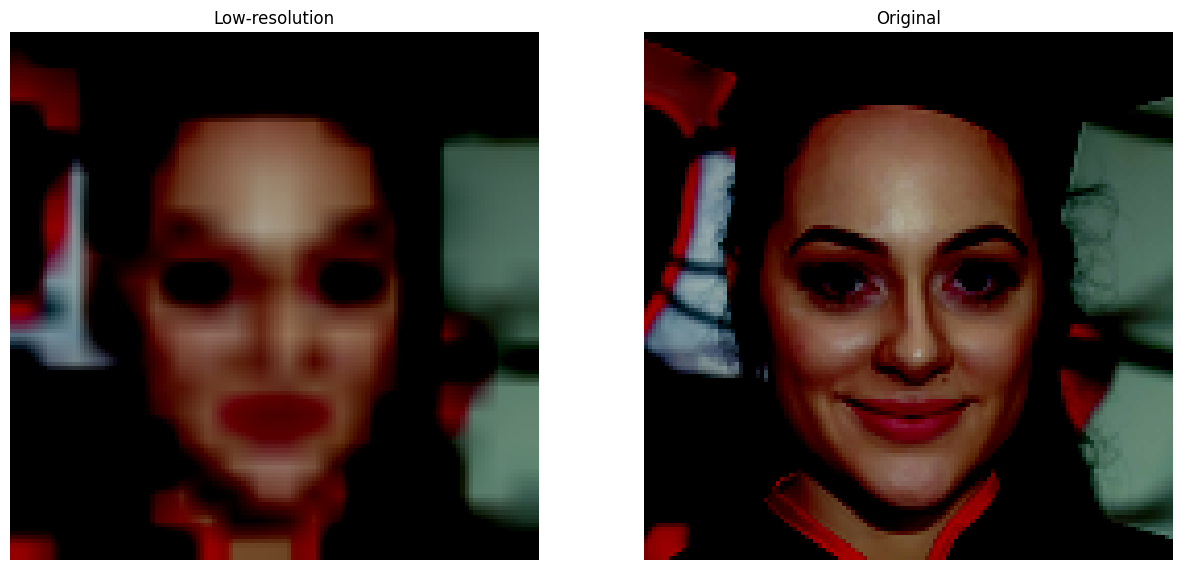

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


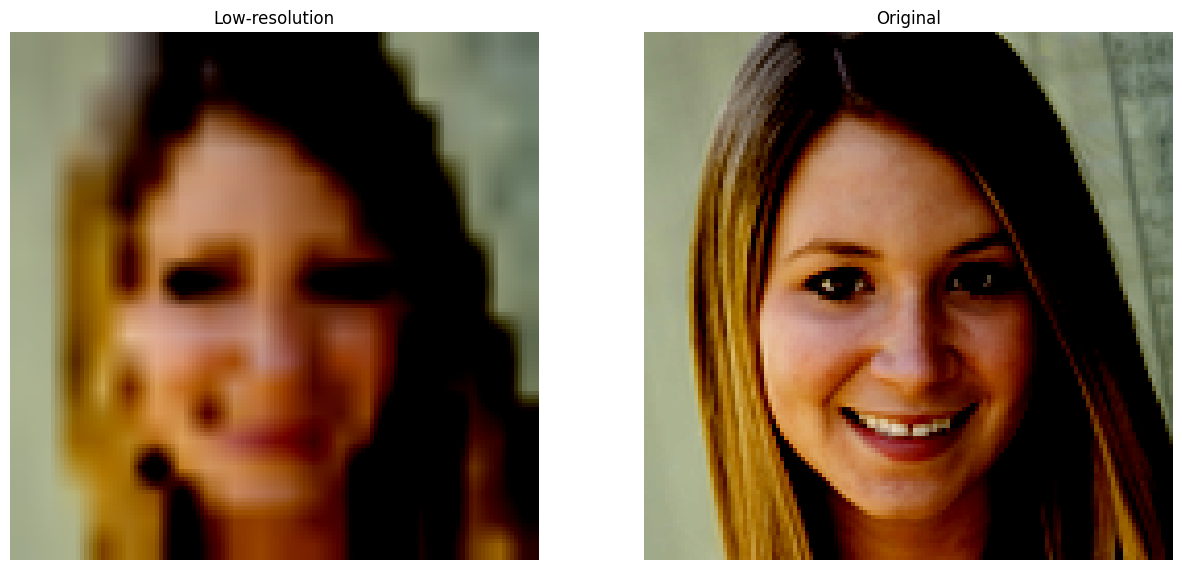

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


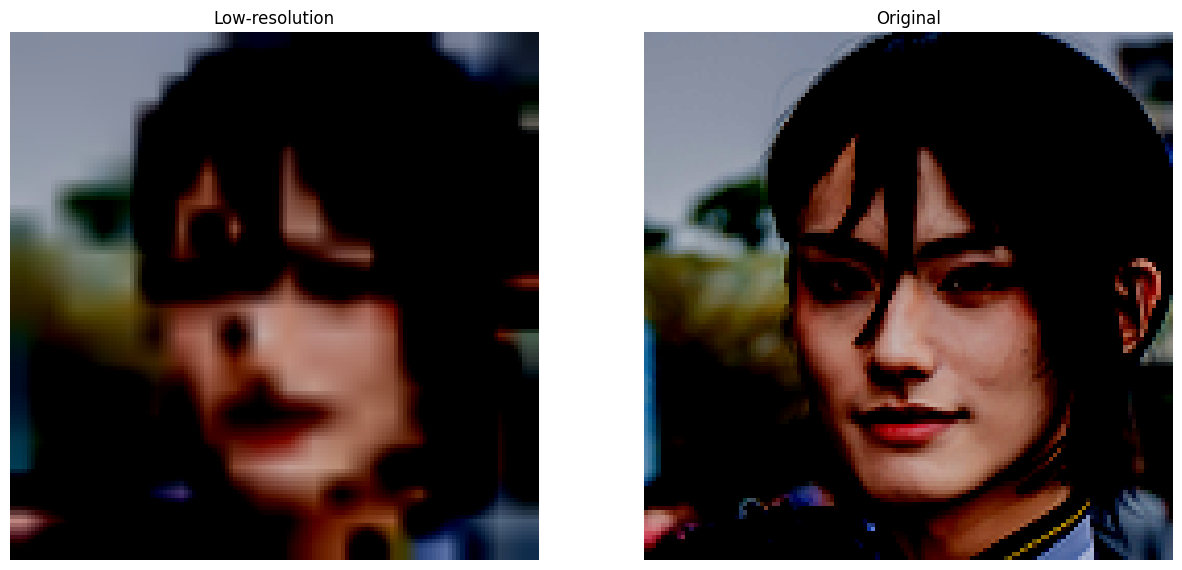

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


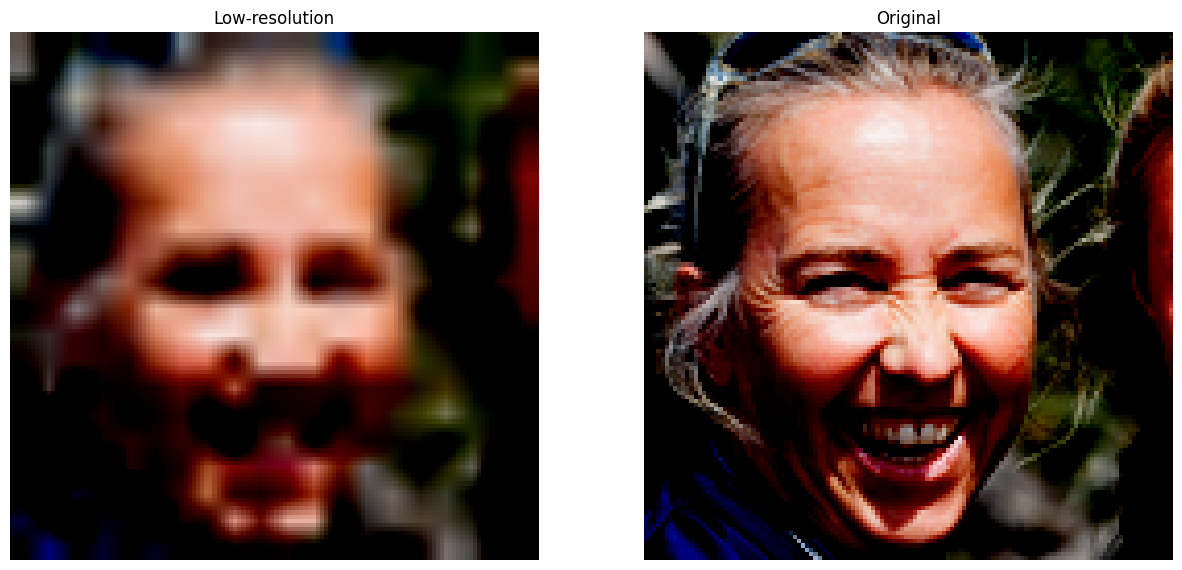

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


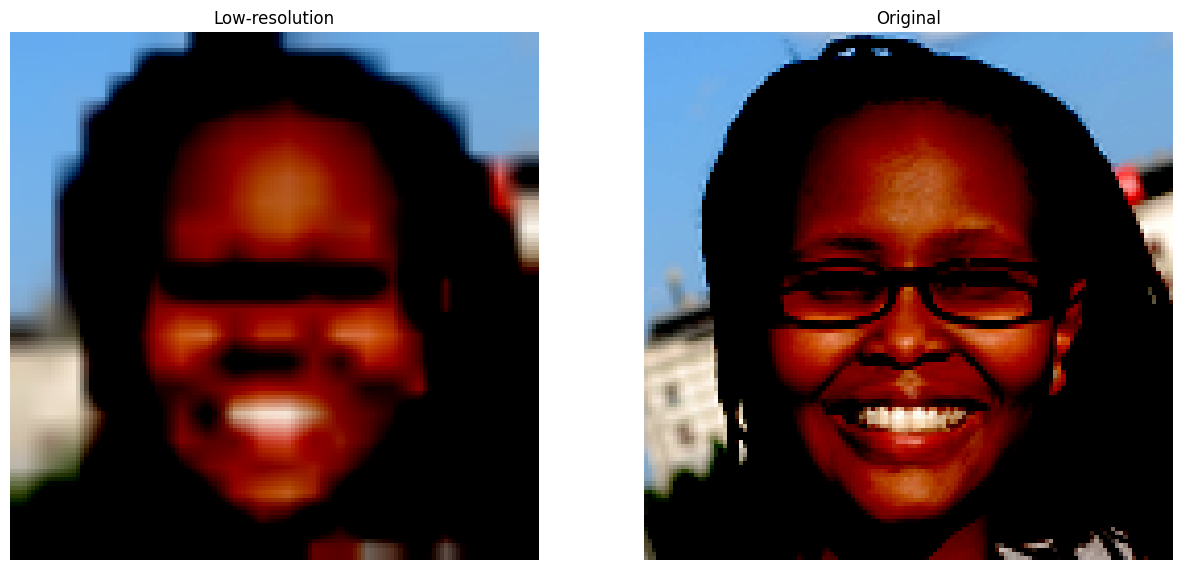

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


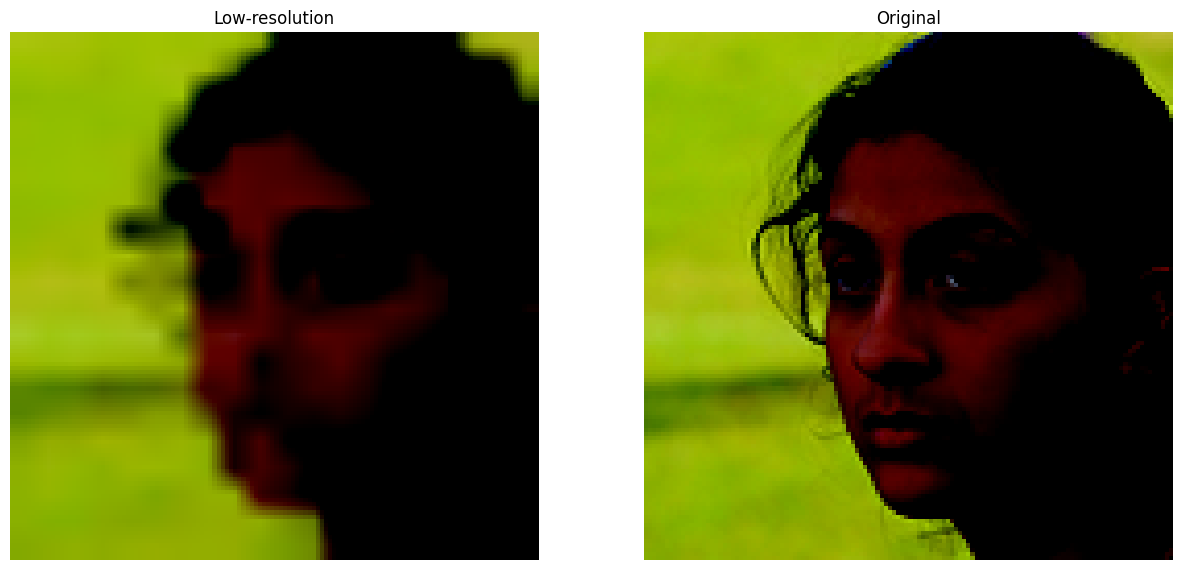

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


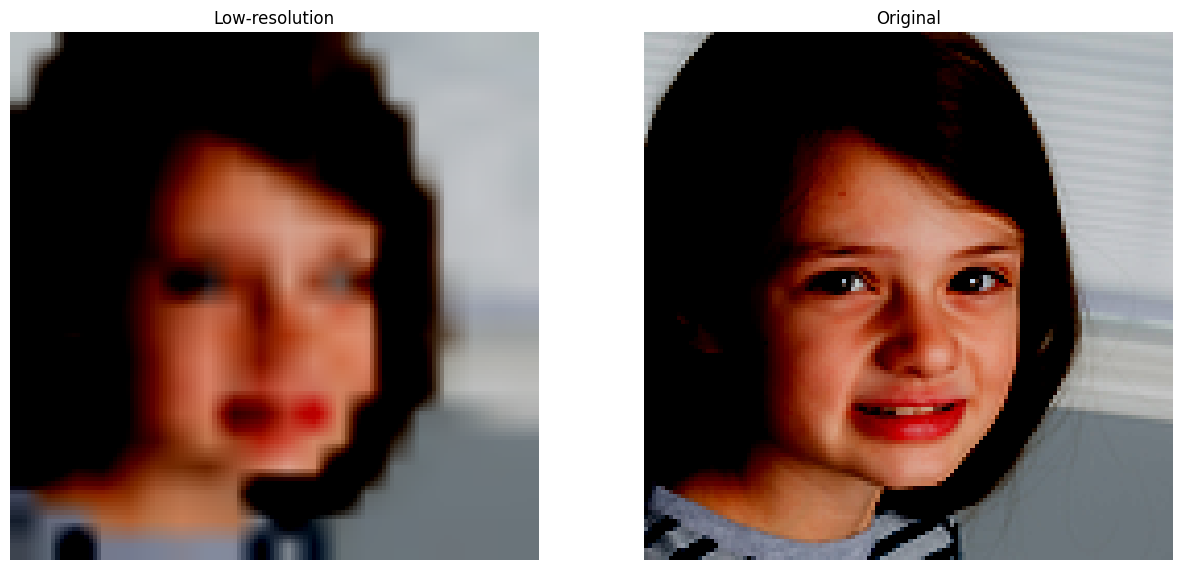

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


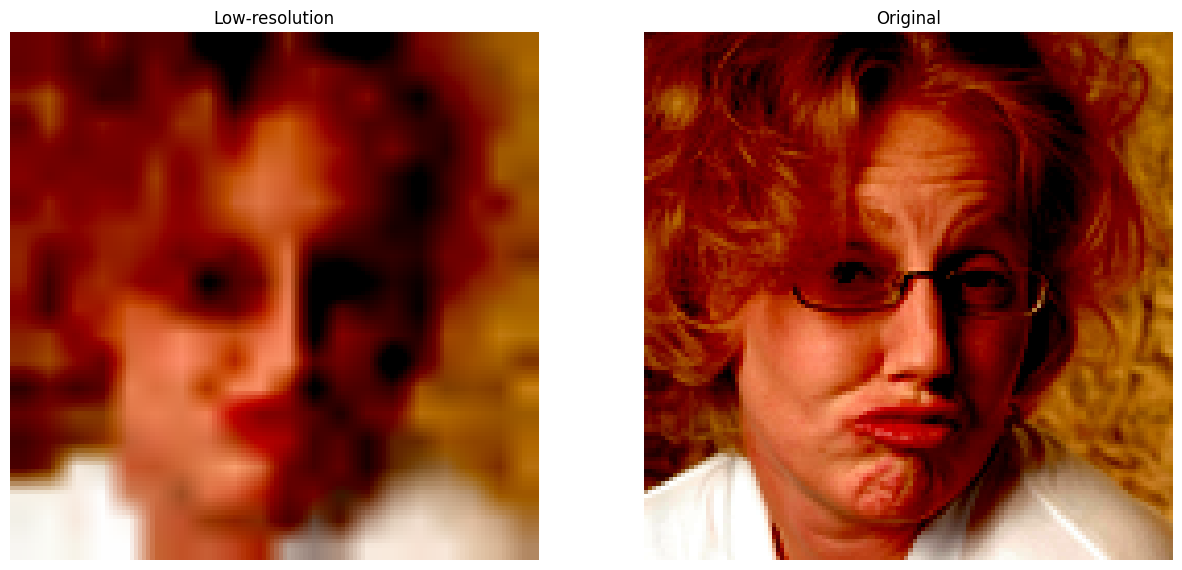

In [263]:
sample_image_batch, _ = next(iter(dataloader))
low_resolution_batch = transforms.Resize(img_size)(transforms.Resize(LR_size)(sample_image_batch))
num_viz = 8
for i in range(num_viz):
    hr_img = sample_image_batch[i].permute(1,2,0).cpu().detach().numpy()
    lr_img = low_resolution_batch[i].permute(1,2,0).cpu().detach().numpy()
    plt.figure(figsize = (15,10))
    plt.subplot(121)
    plt.axis('off')
    plt.title("Low-resolution")
    plt.imshow(lr_img)
    plt.subplot(122)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(hr_img)
    plt.show()

# Schedule with original cosine + L1 Loss

In [264]:
schedule_opt = {'schedule':'cosine', 'n_timestep':2000, 'linear_start':None,'linear_end':None}
args_dict['loss_type'] = 'l1'
args_dict['verbose'] = 5

In [265]:
sr3 = SR3(args_dict,schedule_opt)

loss type: L1


/tmp/ipykernel_98266/2760696207.py:78: RuntimeWarning: invalid value encountered in sqrt
  self.register_buffer('pred_coef_noise', to_torch(np.sqrt(1. / alphas_cumprod - 1)))


In [266]:
sr3.show_my_options()

===Possible beta scheduling types===
1. cosine
2. lengthened_linear

===Possible loss types===
1. l1
2. l2
3. Huber Loss



In [268]:
args_dict.keys()

dict_keys(['load_path', 'load', 'in_channel', 'out_channel', 'inner_channel', 'norm_groups', 'channel_mults', 'res_blocks', 'dropout', 'lr', 'distributed', 'img_size', 'LR_size', 'batch_size', 'device', 'dataloader', 'testloader', 'save_path', 'loss_type', 'verbose'])

In [270]:
args_dict['lr'] = 0.001

In [ ]:
sr3.train(epoch=30, verbose=3)

training...:   0%|          | 0/30 [00:00<?, ?it/s]

running 0th epoch..: 0it [00:00, ?it/s]

running 1th epoch..: 0it [00:00, ?it/s]